# Multilayer Perceptron (MLP)
- MNIST classification 구현하기
- 구글 코랩으로 작성했고, 주피터노트북에는 코드만 붙여놓음

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.10.0+cu111].
device:[cuda:0].


### Dataset

In [12]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


### Data Iterator

In [13]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


### Define the MLP model

In [14]:
class MultiLayerPerceptronClass(nn.Module):
    """
        Multilayer Perceptron (MLP) Class
    """
    def __init__(self,name='mlp',xdim=784,hdim=256,ydim=10):
        super(MultiLayerPerceptronClass,self).__init__()
        self.name = name
        self.xdim = xdim  # MLP의 입력 차원
        self.hdim = hdim  # Hidden 차원
        self.ydim = ydim  # Output 차원

        self.lin_1 = nn.Linear(self.xdim, self.hdim)
        self.lin_2 = nn.Linear(self.hdim, self.ydim)

        self.init_param() # initialize parameters

    # 파이토치는 알아서 nn.Linear call할 때 initialize를 한다.
    # 가끔 새롭게 initialize를 하고 싶으면 따로 custom이 가능함.    
    def init_param(self):
        nn.init.kaiming_normal_(self.lin_1.weight)  # HE init
        nn.init.zeros_(self.lin_1.bias)             # bias = 0
        nn.init.kaiming_normal_(self.lin_2.weight)
        nn.init.zeros_(self.lin_2.bias)

    def forward(self,x):
        net = x
        net = self.lin_1(net)
        net = F.relu(net)
        net = self.lin_2(net)
        return net

M = MultiLayerPerceptronClass(name='mlp',xdim=784,hdim=256,ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(M.parameters(),lr=1e-3)
print ("Done.")

Done.


### Simple Forward Path of the MLP Model

In [15]:
x_numpy = np.random.rand(2,784)

# numpy array를 torch tensor로 변환 후에 float 타입을 맞춘 다음에, 
# device(cpu 또는 gpu)에 넘겨줘야 활용이 가능해짐
x_torch = torch.from_numpy(x_numpy).float().to(device)

# forward path를 통해 y_torch라는 output를 받음
# M(x_torch)처럼 forward 메소드를 생략해도 동일하게 작동한다.
y_torch = M.forward(x_torch) 

# output(tensor 타입)를 보기위해 다시 numpy 타입으로 변환해줌.
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_numpy:\n",x_numpy)
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("y_numpy:\n",y_numpy)

x_numpy:
 [[0.569 0.477 0.849 ... 0.165 0.406 0.134]
 [0.437 0.633 0.643 ... 0.838 0.107 0.904]]
x_torch:
 tensor([[0.5695, 0.4771, 0.8487,  ..., 0.1651, 0.4058, 0.1345],
        [0.4367, 0.6327, 0.6426,  ..., 0.8377, 0.1066, 0.9039]],
       device='cuda:0')
y_torch:
 tensor([[ 0.6558,  0.2504, -0.4320,  2.3544,  0.3073,  0.1046, -0.3388, -0.1086,
         -0.0340,  0.9881],
        [-0.6167, -0.4545, -0.5457,  2.2340,  0.5461, -0.1138, -0.7064, -0.2939,
          0.4043,  1.0218]], device='cuda:0', grad_fn=<AddmmBackward0>)
y_numpy:
 [[ 0.656  0.25  -0.432  2.354  0.307  0.105 -0.339 -0.109 -0.034  0.988]
 [-0.617 -0.454 -0.546  2.234  0.546 -0.114 -0.706 -0.294  0.404  1.022]]


### Check Parameters

In [16]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(M.named_parameters()):
    param_numpy = param.detach().cpu().numpy()
    n_param += len(param_numpy.reshape(-1))
    print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
    print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[lin_1.weight] shape:[(256, 784)].
    val:[-0.011 -0.028 -0.075  0.034  0.061]
[1] name:[lin_1.bias] shape:[(256,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[lin_2.weight] shape:[(10, 256)].
    val:[-0.058 -0.066  0.034  0.084 -0.09 ]
[3] name:[lin_2.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[203,530].


### Evaluation Function

In [17]:
def func_eval(model,data_iter,device):
    with torch.no_grad(): # gradient를 계산하지 않는다.
        model.eval() # evaluate (affects DropOut and BN)
        n_total,n_correct = 0,0
        for batch_in,batch_out in data_iter: # data loader를 통해 X,y를 뽑음
            y_trgt = batch_out.to(device) # target(y) 데이터

            # model forward 진행
            model_pred = model(batch_in.view(-1, 28*28).to(device))
            
            # logits 값이 나오니까 max를 통해 prediction label를 구함(값이 가장 큰 클래스(라벨)를 구함)
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)  # 정확도 계산
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [18]:
M.init_param() # initialize parameters
train_accr = func_eval(M,train_iter,device)
test_accr = func_eval(M,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))
# 모델을 initialize하고 클래스가 10개니까 대충 정확도가 10퍼센트 나옴

train_accr:[0.107] test_accr:[0.106].


### Train

In [20]:
print ("Start training.")
M.init_param() # initialize parameters
M.train()
EPOCHS, print_every = 10, 1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        # 784 dimension으로 reshape하고 device에 올린다.
        y_pred = M.forward(batch_in.view(-1, 28*28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))

        # Update
        optm.zero_grad()     # reset gradient, 파라미터 gradient를 0으로 초기화 
        loss_out.backward()   # backpropagate, 각각의 weight에 대해서 loss가 쌓임
        optm.step()          # optimizer update, weight를 옮김

        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter) # loss값 계산
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(M,train_iter,device) # train 정확도 계산
        test_accr = func_eval(M,test_iter,device)   # test 정확도 계산
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")        

Start training.
epoch:[0] loss:[0.377] train_accr:[0.945] test_accr:[0.942].
epoch:[1] loss:[0.167] train_accr:[0.964] test_accr:[0.958].
epoch:[2] loss:[0.118] train_accr:[0.975] test_accr:[0.967].
epoch:[3] loss:[0.089] train_accr:[0.982] test_accr:[0.972].
epoch:[4] loss:[0.070] train_accr:[0.985] test_accr:[0.975].
epoch:[5] loss:[0.057] train_accr:[0.989] test_accr:[0.977].
epoch:[6] loss:[0.047] train_accr:[0.989] test_accr:[0.978].
epoch:[7] loss:[0.040] train_accr:[0.992] test_accr:[0.977].
epoch:[8] loss:[0.032] train_accr:[0.994] test_accr:[0.980].
epoch:[9] loss:[0.027] train_accr:[0.995] test_accr:[0.980].
Done


### Test

torch.Size([25, 10])
tensor([2, 7, 9, 2, 7, 3, 5, 4, 0, 9, 1, 8, 4, 4, 1, 9, 6, 1, 0, 7, 2, 5, 6, 2,
        8], device='cuda:0')


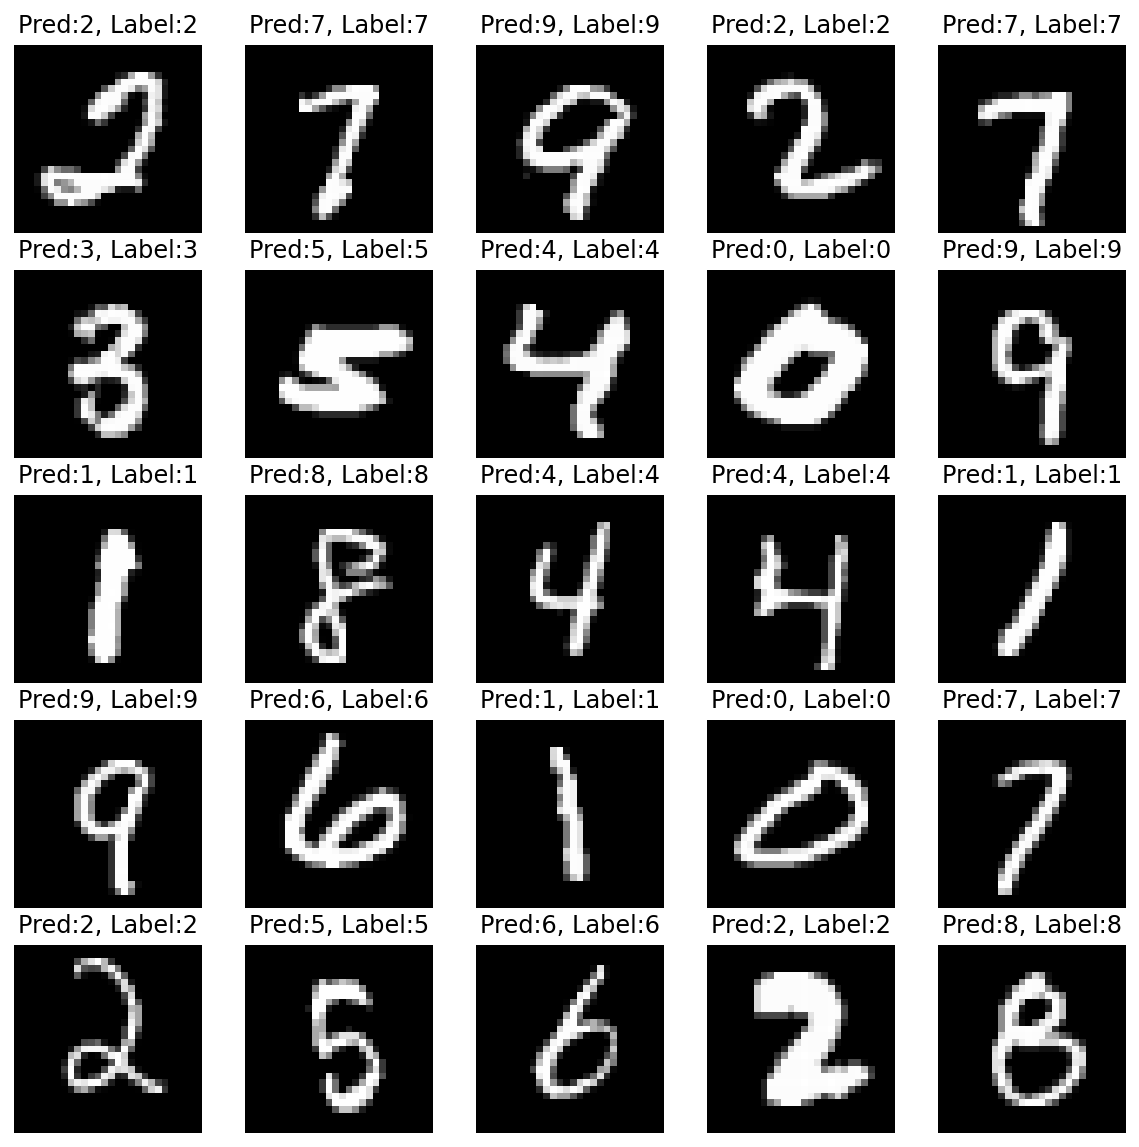

Done


In [25]:
n_sample = 25
# Test dataset에서 25개 샘플링
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices] # test input
test_y = mnist_test.targets[sample_indices] # test output

# 학습된 model에 대해 prediction을 얻고 얼마나 정확한지 확인하기
with torch.no_grad():
    y_pred = M.forward(test_x.view(-1, 28*28).type(torch.float).to(device)/255.)
    print(y_pred.shape)
# 뽑힌 logits에 대해서 argmax로 가장 높은 값을 뽑음(라벨 뽑음)
y_pred = y_pred.argmax(axis=1)
print(y_pred)

plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")